In [1]:
import NN_Module as nnm
import torch
import polynomial as poly
import numpy as np
import numpy.ma as ma
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import math
import time
import pandas as pd
from pandas import read_csv
import argparse
from matplotlib.backends.backend_pdf import PdfPages

In [98]:
out_file = '13028_3'

In [99]:
names = {}
names['cQei'] = 0
names['cQl3i'] = 1
names['cQlMi'] = 2
names['cbW'] = 3
names['cpQ3'] = 4
names['cpQM'] = 5
names['cpt'] = 6
names['cptb'] = 7
names['ctG'] = 8
names['ctW'] = 9
names['ctZ'] = 10
names['ctei'] = 11
names['ctlSi'] = 12
names['ctlTi'] = 13
names['ctli'] = 14
names['ctp'] = 15

In [100]:
save_dict = torch.load(f'/scratch365/njamieso/Likelihood/models/{out_file}_model+.pt')
best_model_state = save_dict['model']
parameters_save = save_dict['parameters']
input_stats = save_dict['input_stats']
output_stats = save_dict['output_stats']

In [101]:
input_stats[0].device

device(type='cuda', index=0)

In [102]:
parameters_save

{'N': 16,
 'train_size': 49378587,
 'test_size': 498773,
 'hidden_nodes': 600,
 'hidden_layers': 3,
 'batch_size': 512,
 'n_epochs': 438,
 'learning_rate': 0.0001,
 'lr_red_factor': 0.2,
 'lr_red_patience': 25.0,
 'lr_red_threshold': 1e-06,
 'weight_decay': 0.0,
 'polynomial': True,
 'polynomial_degree': 4,
 'accu_out_resolution': 100,
 'out_residual_resolution': 100}

In [103]:
if(parameters_save['polynomial']):
    model = nnm.create_model(16, 1, parameters_save) # Hard-coded for the inclusion of square and cross terms
else:
    model = nnm.create_model(poly.MonomialLayer(16, parameters_save['polynomial_degree']), 1, parameters_save)
model.load_state_dict(best_model_state)
model.eval()

Sequential(
  (0): PolynomialLayer(
    (monomial_layer): MonomialLayer()
    (linear): Linear(in_features=4844, out_features=600, bias=True)
  )
  (1): ReLU()
  (2): Linear(in_features=600, out_features=600, bias=True)
  (3): ReLU()
  (4): Linear(in_features=600, out_features=600, bias=True)
  (5): ReLU()
  (6): Linear(in_features=600, out_features=600, bias=True)
  (7): ReLU()
  (8): Linear(in_features=600, out_features=1, bias=True)
)

In [104]:
actual_frozen_graph_data = {}
for key in names.keys():
    loaded = np.load(f'data/likelihood_{key}.npz')
    actual_frozen_graph_data[key] = {key: loaded[key], 'deltaNLL': loaded['deltaNLL']}
    actual_frozen_graph_data[key]['deltaNLL'] -= actual_frozen_graph_data[key]['deltaNLL'].min()
    actual_frozen_graph_data[key]['deltaNLL'] *= 2


In [105]:
actual_profiled_graph_data = {}
for key in names.keys():
    loaded = np.load(f'data/likelihood_profiled_{key}.npz')
    inputs = np.zeros((loaded['deltaNLL'].shape[0], 16))
    
    for key2 in names.keys():
        inputs[:,names[key2]] = loaded[key2]
    actual_profiled_graph_data[key] = {key: inputs, 'deltaNLL': loaded['deltaNLL']}
    actual_profiled_graph_data[key]['deltaNLL'] -= actual_profiled_graph_data[key]['deltaNLL'].min()
    actual_profiled_graph_data[key]['deltaNLL'] *= 2

In [106]:
actual_zoomed_frozen_graph_data = {}
for key in names.keys():
    less_than_10 = (actual_frozen_graph_data[key]['deltaNLL'] < 10)
    actual_zoomed_frozen_graph_data[key] = {key: actual_frozen_graph_data[key][key][less_than_10], 'deltaNLL': actual_frozen_graph_data[key]['deltaNLL'][less_than_10]}

In [107]:
actual_zoomed_profiled_graph_data = {}
for key in names.keys():
    less_than_10 = (actual_profiled_graph_data[key]['deltaNLL'] < 10)
    actual_zoomed_profiled_graph_data[key] = {key: actual_profiled_graph_data[key][key][less_than_10], 'deltaNLL': actual_profiled_graph_data[key]['deltaNLL'][less_than_10]}

In [108]:
model_frozen_graph_data = {}
diff_graph_data = {}
for key in names.keys():
    inputs = actual_frozen_graph_data[key][key]
    num_inputs = inputs.shape[0]
    if (parameters_save['polynomial']):
        inputs_all = np.zeros((num_inputs, 16))
        inputs_all[:,names[key]] = inputs
    else:
        inputs_all = np.zeros((num_inputs, 152))
        inputs_all[:,names[key]] = inputs
        inputs_all[:,16:32] = inputs_all[:,0:16]**2
        idx = 32
        for i in range(16):
            for j in range(i):
                inputs_all[:,idx] = inputs_all[:,i] * inputs_all[:,j]
                idx += 1
    std_inputs = nnm.affine_transform(torch.from_numpy(inputs_all).float().cuda(), input_stats)
    std_outputs = model(std_inputs)
    outputs = nnm.affine_untransform(std_outputs, output_stats).cpu().detach().numpy().flatten()
    outputs -= outputs.min()
    outputs *= 2
    model_frozen_graph_data[key] = {key: inputs, 'deltaNLL': outputs}
    diff_graph_data[key] = {key: inputs, 'deltaNLL': actual_frozen_graph_data[key]['deltaNLL'] - outputs}

In [109]:
model_profiled_graph_data = {}
diff_graph_data_profiled = {}
for key in names.keys():
    inputs = actual_profiled_graph_data[key][key]
    num_inputs = inputs.shape[0]
    if (parameters_save['polynomial']):
        inputs_all = np.zeros((num_inputs, 16))
        inputs_all[:,0:16] = inputs
    else:
        inputs_all = np.zeros((num_inputs, 16))
        inputs_all[:,0:16] = inputs
        inputs_all[:,16:32] = inputs_all[:,0:16]**2
        idx = 32
        for i in range(16):
            for j in range(i):
                inputs_all[:,idx] = inputs_all[:,i] * inputs_all[:,j]
                idx += 1
    std_inputs = nnm.affine_transform(torch.from_numpy(inputs_all).float().cuda(), input_stats)
    std_outputs = model(std_inputs)
    outputs = nnm.affine_untransform(std_outputs, output_stats).cpu().detach().numpy().flatten()
    outputs -= outputs.min()
    outputs *= 2
    model_profiled_graph_data[key] = {key: inputs[:,names[key]], 'deltaNLL': outputs}
    diff_graph_data_profiled[key] = {key: inputs, 'deltaNLL': actual_profiled_graph_data[key]['deltaNLL'] - outputs}

In [110]:
model_zoomed_frozen_graph_data = {}
diff_graph_data_zoomed = {}
for key in names.keys():
    less_than_10 = (actual_frozen_graph_data[key]['deltaNLL'] < 10)
    model_zoomed_frozen_graph_data[key] = {key: model_frozen_graph_data[key][key][less_than_10], 'deltaNLL': model_frozen_graph_data[key]['deltaNLL'][less_than_10]}
    diff_graph_data_zoomed[key] = {key: model_zoomed_frozen_graph_data[key][key], 'deltaNLL': actual_frozen_graph_data[key]['deltaNLL'][less_than_10] - model_zoomed_frozen_graph_data[key]['deltaNLL']}

In [111]:
model_zoomed_profiled_graph_data = {}
diff_graph_data_zoomed_profiled = {}
for key in names.keys():
    less_than_10 = (actual_profiled_graph_data[key]['deltaNLL'] < 10)
    model_zoomed_profiled_graph_data[key] = {key: model_profiled_graph_data[key][key][less_than_10], 'deltaNLL': model_profiled_graph_data[key]['deltaNLL'][less_than_10]}
    diff_graph_data_zoomed_profiled[key] = {key: model_zoomed_profiled_graph_data[key][key], 'deltaNLL': actual_profiled_graph_data[key]['deltaNLL'][less_than_10] - model_zoomed_profiled_graph_data[key]['deltaNLL']}

/srv/ipykernel_40/3542790105.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  diff_graphs[key] = plt.subplots()


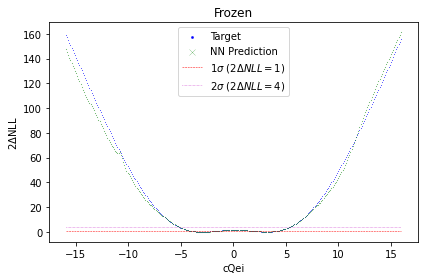

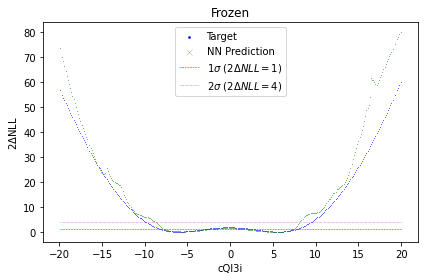

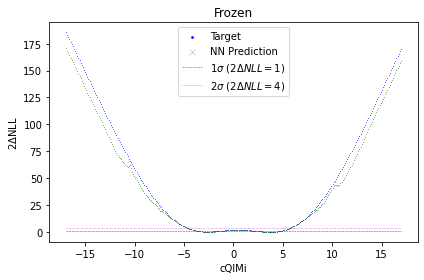

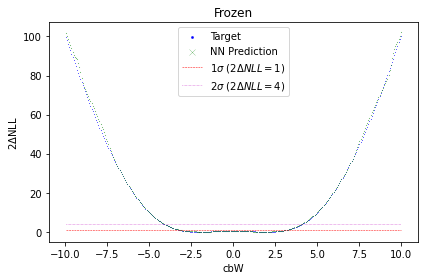

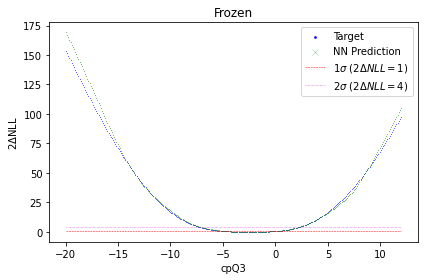

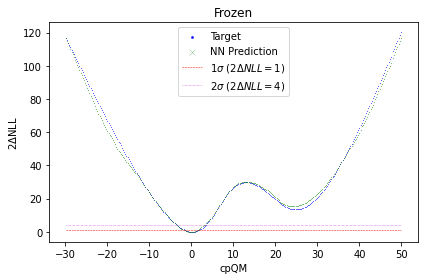

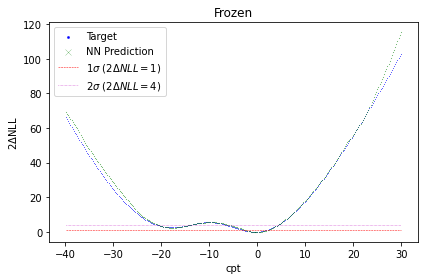

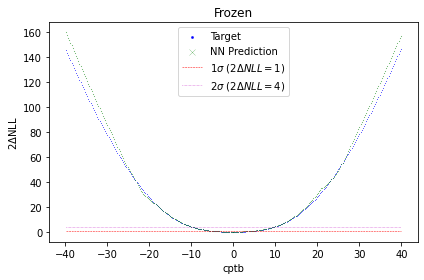

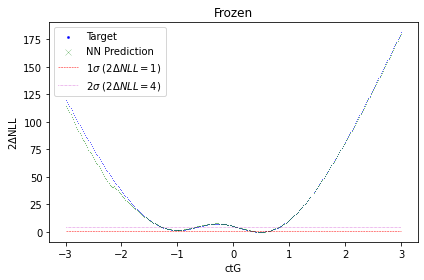

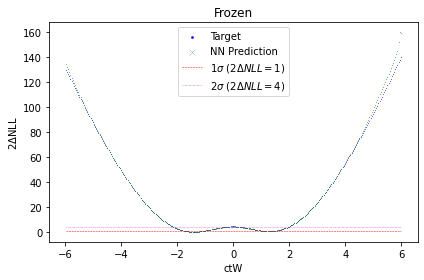

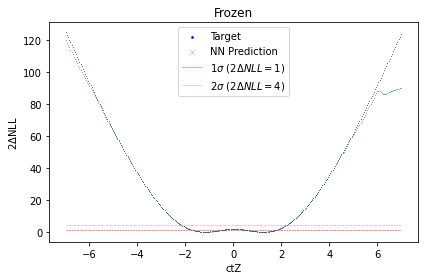

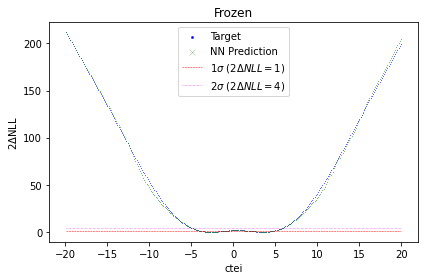

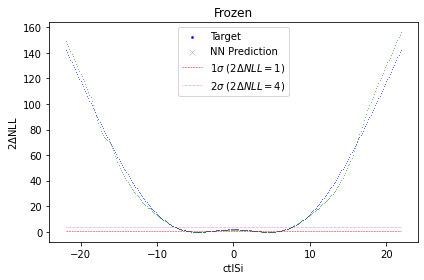

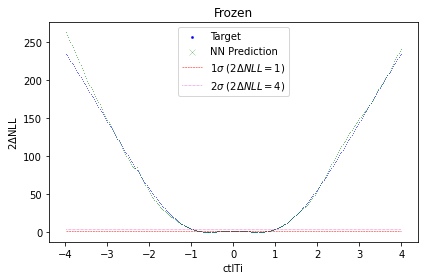

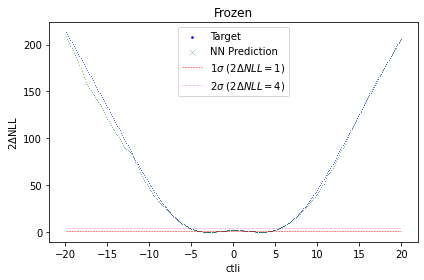

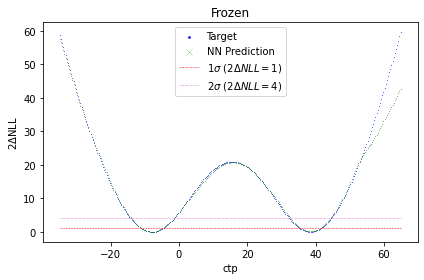

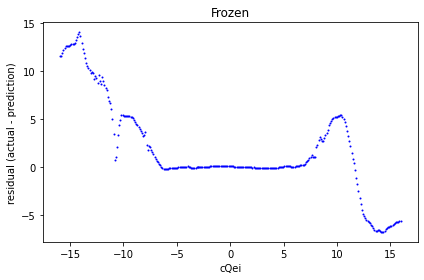

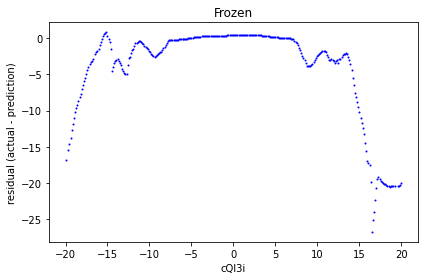

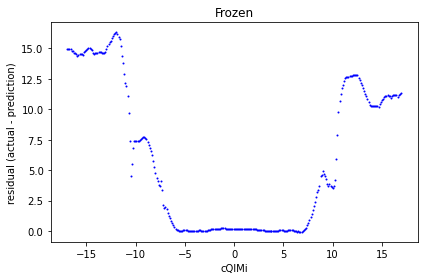

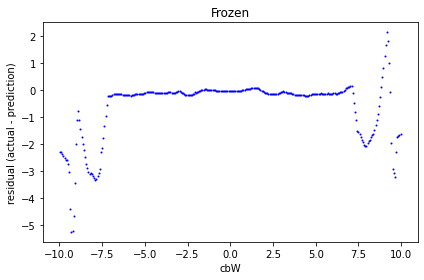

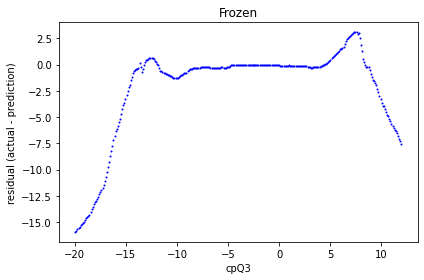

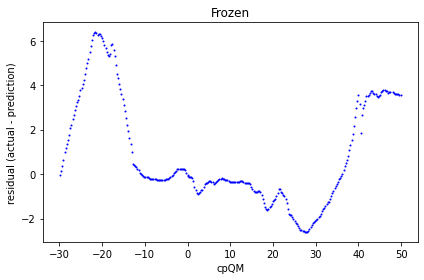

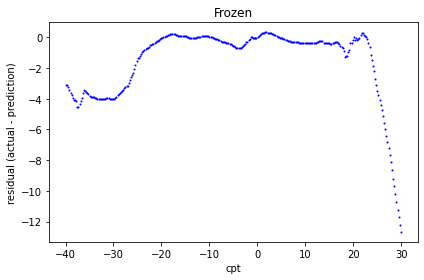

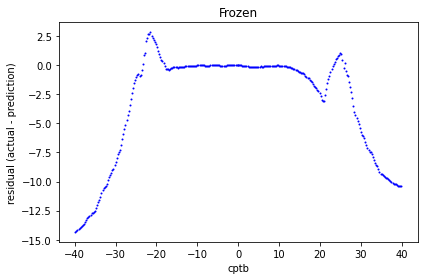

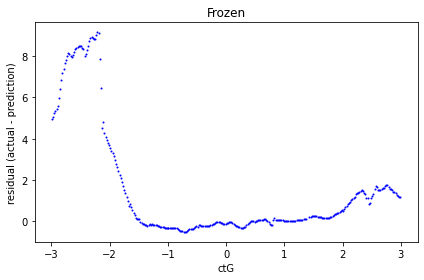

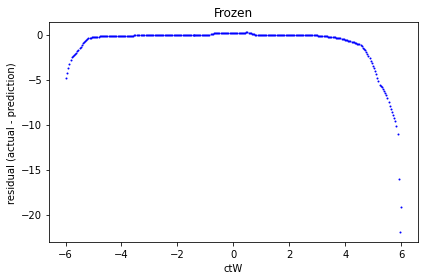

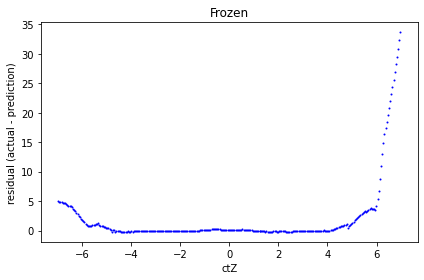

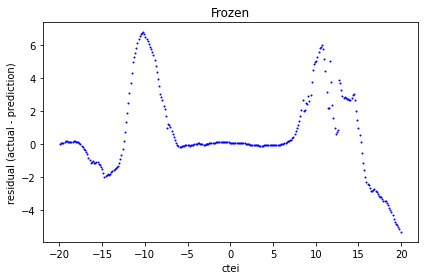

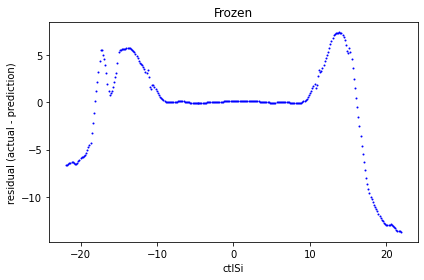

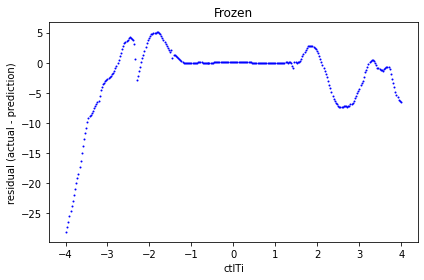

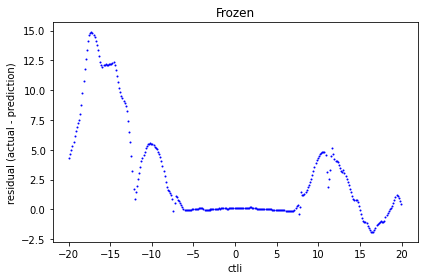

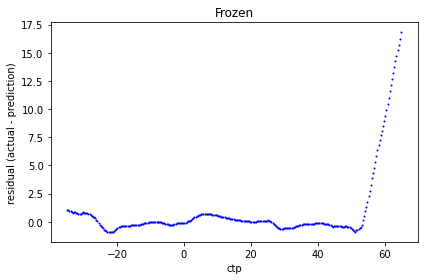

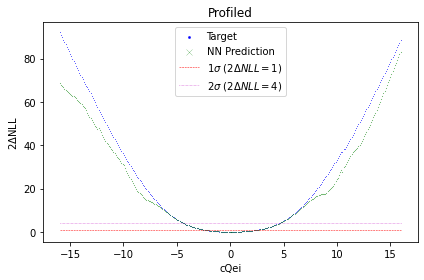

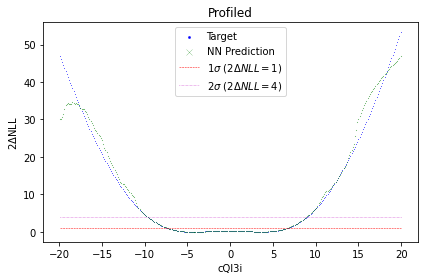

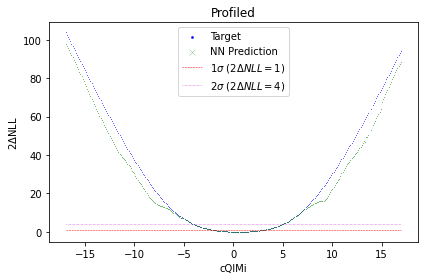

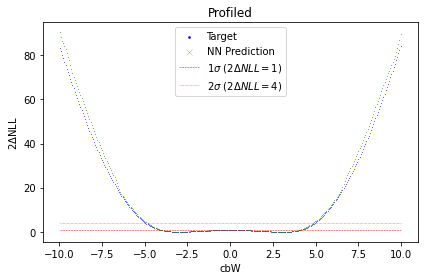

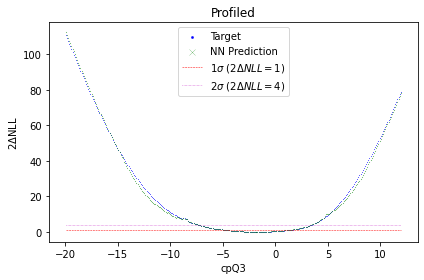

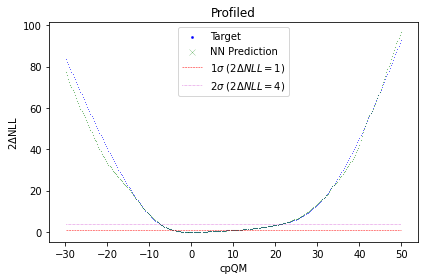

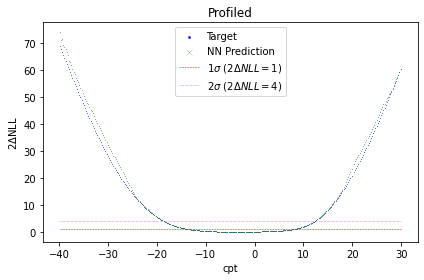

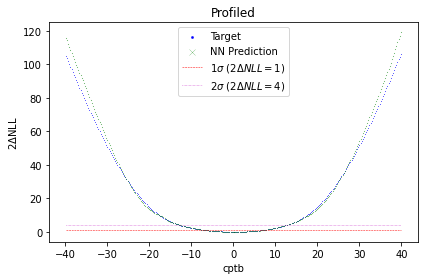

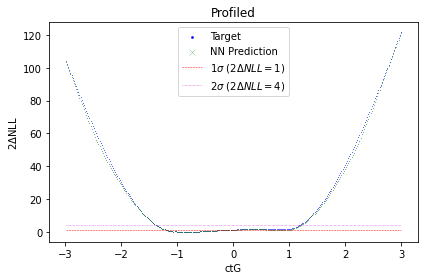

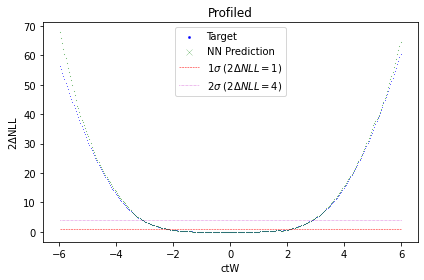

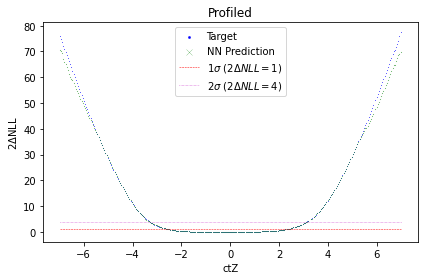

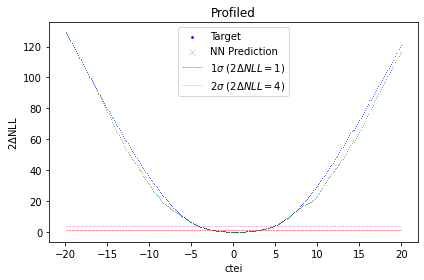

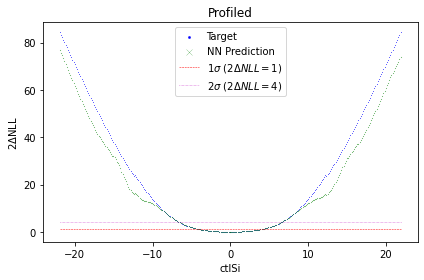

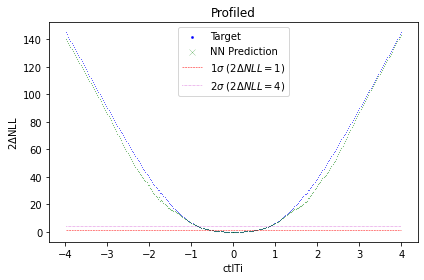

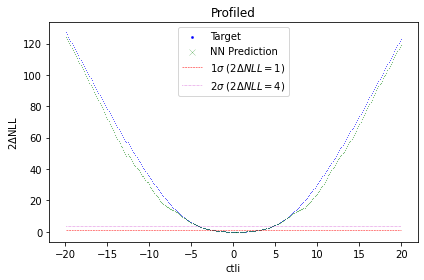

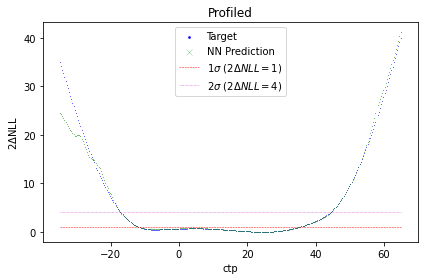

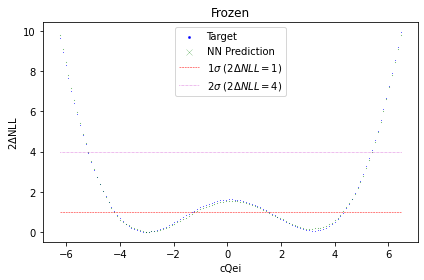

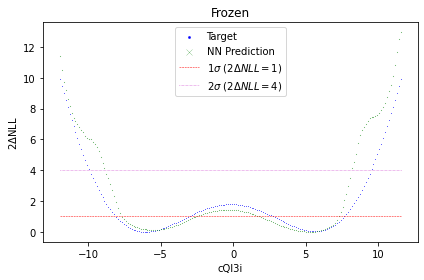

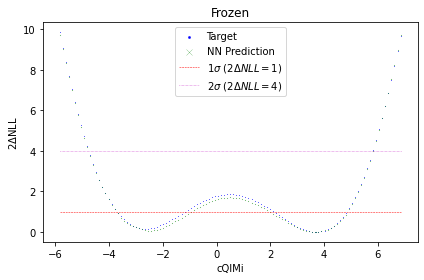

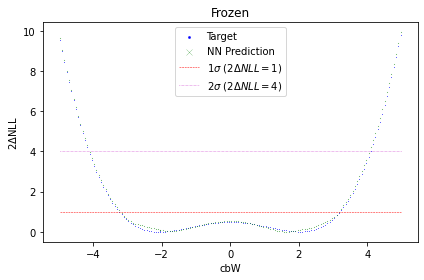

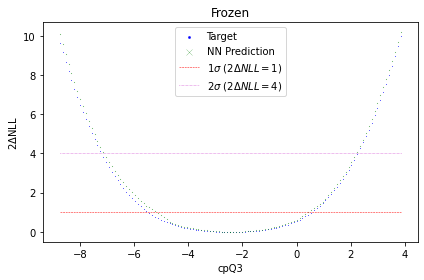

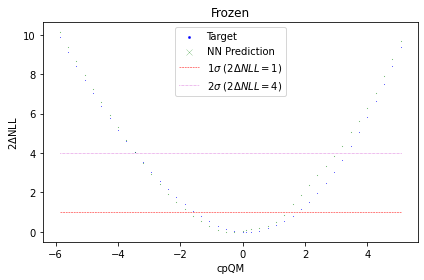

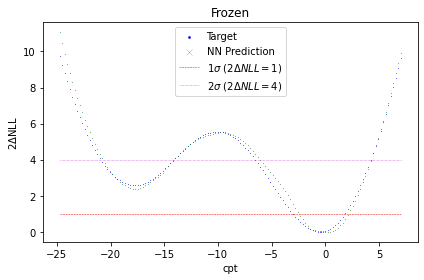

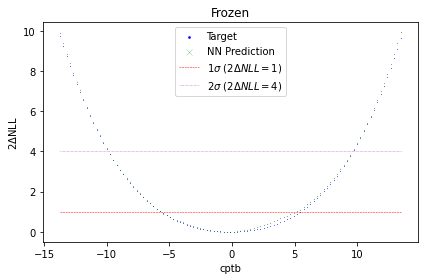

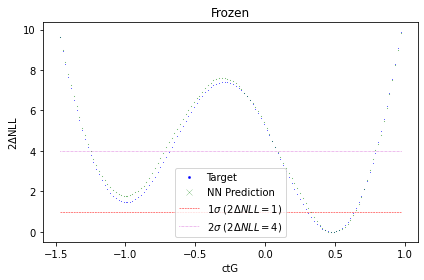

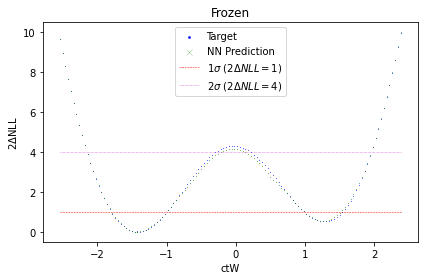

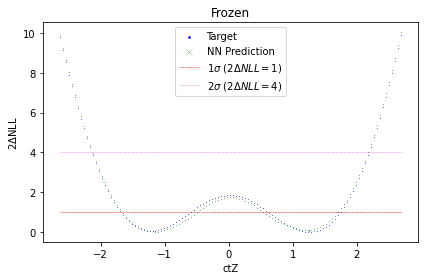

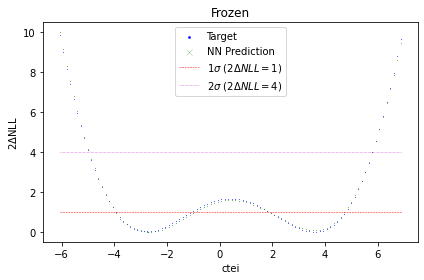

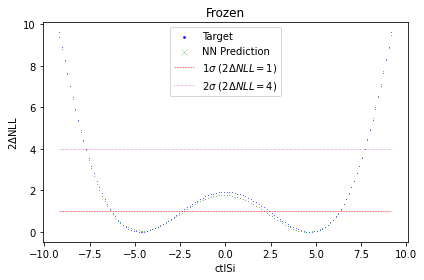

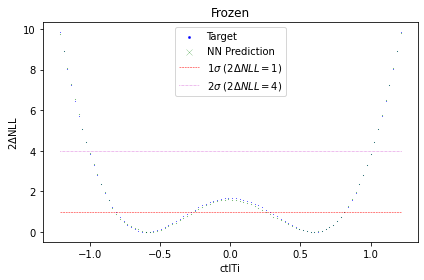

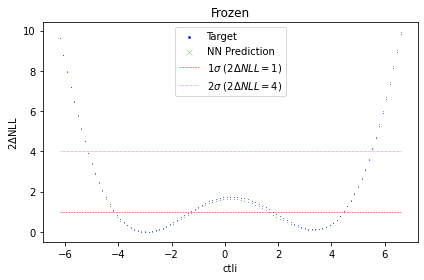

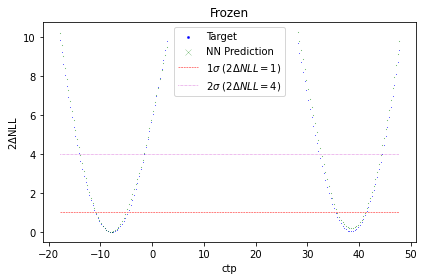

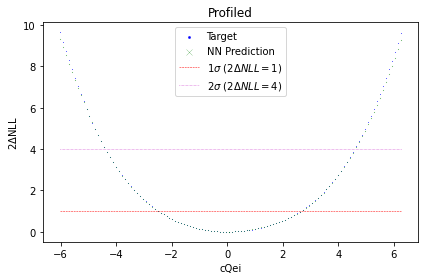

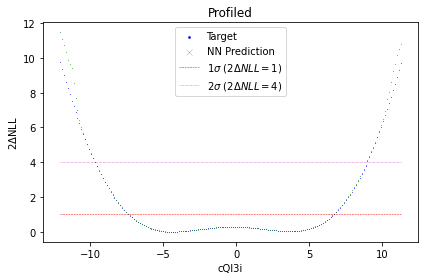

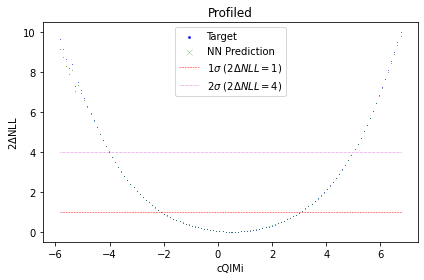

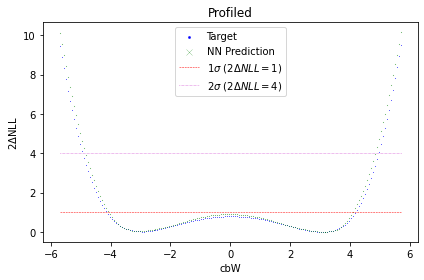

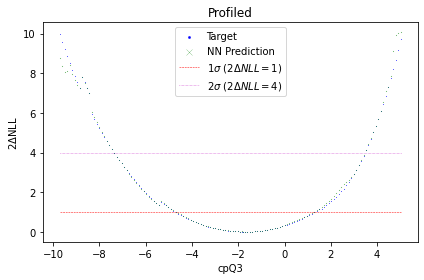

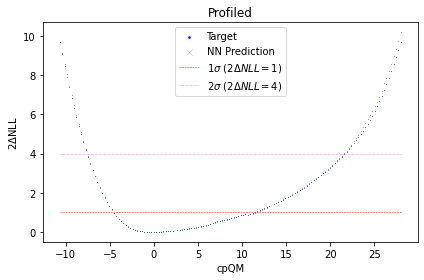

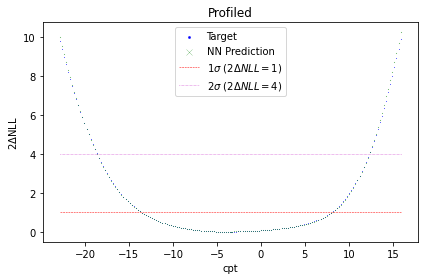

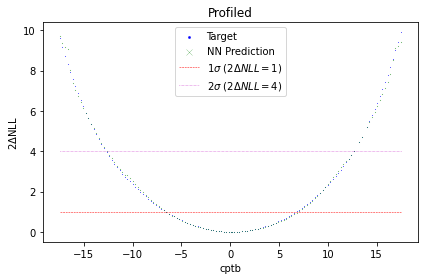

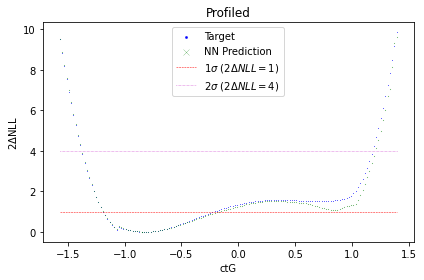

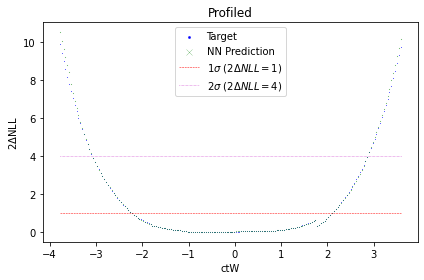

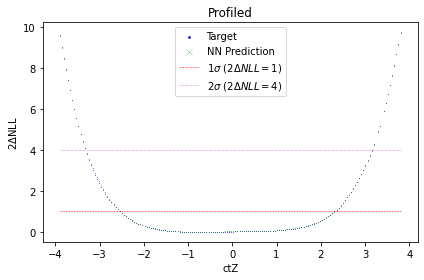

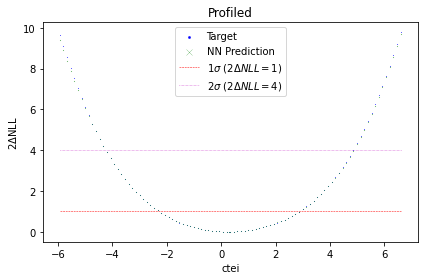

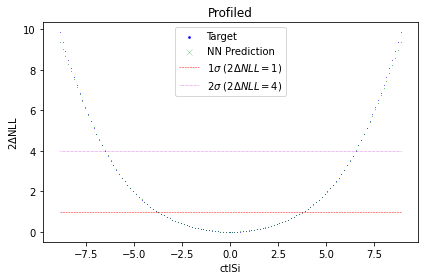

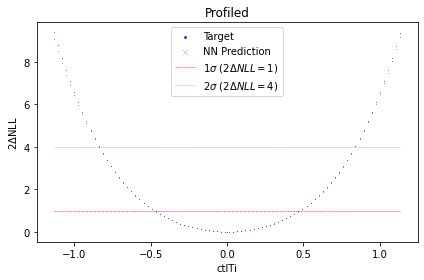

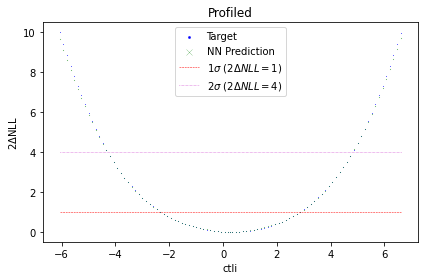

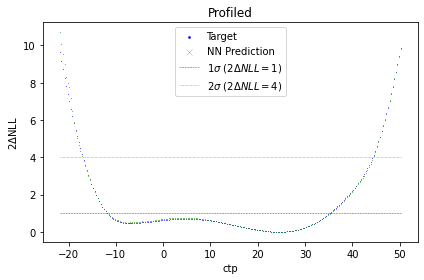

In [112]:
frozen_graphs = {}
diff_graphs = {}
profiled_graphs = {}
zoomed_frozen_graphs = {}
zoomed_profiled_graphs = {}
for key in names.keys():
    frozen_graphs[key] = plt.subplots()
    actual_scatter = frozen_graphs[key][1].scatter(actual_frozen_graph_data[key][key], actual_frozen_graph_data[key]['deltaNLL'], marker='.', c='b', s=0.5, linewidths=0.5)
    model_scatter = frozen_graphs[key][1].scatter(model_frozen_graph_data[key][key], model_frozen_graph_data[key]['deltaNLL'], marker='x', c='g', s=1, linewidths=0.2)
    one_line, = frozen_graphs[key][1].plot([model_frozen_graph_data[key][key].min(), model_frozen_graph_data[key][key].max()], [1,1], 'r--', linewidth=0.5)
    four_line, = frozen_graphs[key][1].plot([model_frozen_graph_data[key][key].min(), model_frozen_graph_data[key][key].max()], [4,4], 'm:', linewidth=0.5)
    frozen_graphs[key][1].legend([actual_scatter, model_scatter, one_line, four_line], ['Target', 'NN Prediction', '$1\sigma\ (2\Delta NLL=1)$', '$2\sigma\ (2\Delta NLL=4)$'], markerscale=6)
    frozen_graphs[key][1].set_xlabel(key)
    frozen_graphs[key][1].set_ylabel('2$\Delta$NLL')
    frozen_graphs[key][1].set_title('Frozen')
    frozen_graphs[key][0].tight_layout()

for key in names.keys():
    diff_graphs[key] = plt.subplots()
    diff_graphs[key][1].scatter(diff_graph_data[key][key], diff_graph_data[key]['deltaNLL'], c='b', s=1)
    diff_graphs[key][1].set_xlabel(key)
    diff_graphs[key][1].set_ylabel('residual (actual - prediction)')
    diff_graphs[key][1].set_title('Frozen')
    diff_graphs[key][0].tight_layout()

for key in names.keys():
    profiled_graphs[key] = plt.subplots()
    actual_scatter = profiled_graphs[key][1].scatter(model_profiled_graph_data[key][key], actual_profiled_graph_data[key]['deltaNLL'], marker='.', c='b', s=0.5, linewidths=0.5)
    model_scatter = profiled_graphs[key][1].scatter(model_profiled_graph_data[key][key], model_profiled_graph_data[key]['deltaNLL'], marker='x', c='g', s=1, linewidths=0.2)
    one_line, = profiled_graphs[key][1].plot([model_profiled_graph_data[key][key].min(), model_profiled_graph_data[key][key].max()], [1,1], 'r--', linewidth=0.5)
    four_line, = profiled_graphs[key][1].plot([model_profiled_graph_data[key][key].min(), model_profiled_graph_data[key][key].max()], [4,4], 'm:', linewidth=0.5)
    profiled_graphs[key][1].legend([actual_scatter, model_scatter, one_line, four_line], ['Target', 'NN Prediction', '$1\sigma\ (2\Delta NLL=1)$', '$2\sigma\ (2\Delta NLL=4)$'], markerscale=6)
    profiled_graphs[key][1].set_xlabel(key)
    profiled_graphs[key][1].set_ylabel('2$\Delta$NLL')
    profiled_graphs[key][1].set_title('Profiled')
    profiled_graphs[key][0].tight_layout()
    
for key in names.keys():
    zoomed_frozen_graphs[key] = plt.subplots()
    actual_scatter = zoomed_frozen_graphs[key][1].scatter(actual_zoomed_frozen_graph_data[key][key], actual_zoomed_frozen_graph_data[key]['deltaNLL'], marker='.', c='b', s=0.5, linewidths=0.5)
    model_scatter = zoomed_frozen_graphs[key][1].scatter(model_zoomed_frozen_graph_data[key][key], model_zoomed_frozen_graph_data[key]['deltaNLL'], marker='x', c='g', s=1, linewidths=0.2)
    one_line, = zoomed_frozen_graphs[key][1].plot([model_zoomed_frozen_graph_data[key][key].min(), model_zoomed_frozen_graph_data[key][key].max()], [1,1], 'r--', linewidth=0.5)
    four_line, = zoomed_frozen_graphs[key][1].plot([model_zoomed_frozen_graph_data[key][key].min(), model_zoomed_frozen_graph_data[key][key].max()], [4,4], 'm:', linewidth=0.5)
    zoomed_frozen_graphs[key][1].legend([actual_scatter, model_scatter, one_line, four_line], ['Target', 'NN Prediction', '$1\sigma\ (2\Delta NLL=1)$', '$2\sigma\ (2\Delta NLL=4)$'], markerscale=6)
    zoomed_frozen_graphs[key][1].set_xlabel(key)
    zoomed_frozen_graphs[key][1].set_ylabel('2$\Delta$NLL')
    zoomed_frozen_graphs[key][1].set_title('Frozen')
    zoomed_frozen_graphs[key][0].tight_layout()
    
for key in names.keys():
    zoomed_profiled_graphs[key] = plt.subplots()
    actual_scatter = zoomed_profiled_graphs[key][1].scatter(model_zoomed_profiled_graph_data[key][key], actual_zoomed_profiled_graph_data[key]['deltaNLL'], marker='.', c='b', s=0.5, linewidths=0.5)
    model_scatter = zoomed_profiled_graphs[key][1].scatter(model_zoomed_profiled_graph_data[key][key], model_zoomed_profiled_graph_data[key]['deltaNLL'], marker='x', c='g', s=1, linewidths=0.2)
    one_line, = zoomed_profiled_graphs[key][1].plot([model_zoomed_profiled_graph_data[key][key].min(), model_zoomed_profiled_graph_data[key][key].max()], [1,1], 'r--', linewidth=0.5)
    four_line, = zoomed_profiled_graphs[key][1].plot([model_zoomed_profiled_graph_data[key][key].min(), model_zoomed_profiled_graph_data[key][key].max()], [4,4], 'm:', linewidth=0.5)
    zoomed_profiled_graphs[key][1].legend([actual_scatter, model_scatter, one_line, four_line], ['Target', 'NN Prediction', '$1\sigma\ (2\Delta NLL=1)$', '$2\sigma\ (2\Delta NLL=4)$'], markerscale=6)
    zoomed_profiled_graphs[key][1].set_xlabel(key)
    zoomed_profiled_graphs[key][1].set_ylabel('2$\Delta$NLL')
    zoomed_profiled_graphs[key][1].set_title('Profiled')
    zoomed_profiled_graphs[key][0].tight_layout()

In [113]:
pp = PdfPages(f'./graphs/{out_file}_validation.pdf')
for key in frozen_graphs.keys():
    pp.savefig(frozen_graphs[key][0])
for key in diff_graphs.keys():
    pp.savefig(diff_graphs[key][0])
for key in profiled_graphs.keys():
    pp.savefig(profiled_graphs[key][0])
for key in zoomed_frozen_graphs.keys():
    pp.savefig(zoomed_frozen_graphs[key][0])
for key in zoomed_profiled_graphs.keys():
    pp.savefig(zoomed_profiled_graphs[key][0])
torch.save({
    'frozen_graphs': frozen_graphs,
    'diff_graphs': diff_graphs,
    'diff_graph_data': diff_graph_data,
    'diff_graph_data_profiled':diff_graph_data_profiled,
    'diff_graph_data_zoomed':diff_graph_data_zoomed,
    'diff_graph_data_zoomed_profiled':diff_graph_data_zoomed_profiled,
    'profiled_graphs': profiled_graphs,
    'zoomed_frozen_graphs': zoomed_frozen_graphs,
    'zoomed_profiled_graphs': zoomed_profiled_graphs},
    f'./graphs/{out_file}_validation_graphs.npz'
)
pp.close()

In [ ]:
# Measure evaluation time
inputs = 10 * np.random.normal(size=(100000,16))
start_time = time.perf_counter()
num_inputs = inputs.shape[0]
inputs_all = np.zeros((num_inputs, 152))
inputs_all[:,0:16] = inputs
inputs_all[:,16:32] = inputs_all[:,0:16]**2
idx = 32
for i in range(16):
    for j in range(i):
        inputs_all[:,idx] = inputs_all[:,i] * inputs_all[:,j]
        idx += 1
std_inputs = nnm.affine_transform(torch.from_numpy(inputs_all).float().cuda(), input_stats)
std_outputs = model(std_inputs)
outputs = nnm.affine_untransform(std_outputs, output_stats).cpu().detach().numpy().flatten()
print ((time.perf_counter() - start_time) / 100000)

In [ ]:
# Test single points
loaded_data = np.load('../likelihood_data.npz')
use_it = (loaded_data['deltaNLL'] != 0)
use_it[0] = True # Keep the first of the repeated entries
outputs_all_full = loaded_data['deltaNLL'][use_it]
inputs_all_full = []
for key in names.keys():
    inputs_all_full.append(loaded_data[key][use_it])
inputs_all_full = np.stack(inputs_all_full, axis=1)

In [ ]:
# Add the squares of the variables and cross terms
inputs_list = []
inputs_list.append(inputs_all_full)
inputs_all_full_squared = inputs_all_full ** 2
inputs_list.append(inputs_all_full_squared)
# Add the cross terms
for i in range(16):
    for j in range(i):
        inputs_list.append(np.expand_dims(inputs_all_full[:,i] *  inputs_all_full[:,j], axis=1))
inputs_all_full = np.concatenate(inputs_list, axis=1)

In [ ]:
inputs_full = torch.from_numpy(inputs_all_full)
outputs_full = torch.unsqueeze(torch.from_numpy(outputs_all_full), 1)

In [ ]:
outputs_full[outputs_full>100]

In [ ]:
inputs_full[(outputs_full>100).squeeze()][0]

In [ ]:
model(inputs_full[(outputs_full>100).squeeze()][2])

In [ ]:
inputs_full[10000]

In [ ]:
outputs_full[10000]

In [ ]:
model(inputs_full[10000])